In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [2]:
pedestals=pd.read_csv("pedestals.csv", sep=',')
pedestals=pedestals.drop(columns=['pedestal_per_time_sample', 'std_dev', 'mean'])

In [3]:
mips=pd.read_csv("mip.csv", sep=',')
mips=mips.drop(columns=['eta', 'sigma', 'A'])

In [4]:
def choose_bar(df,layer, strip):
    df=df[df["strip"]==strip]
    df=df[df["layer"]==layer]
    return df

In [5]:
def choose_layer(df,layer):
    df=df[df['layer']==layer]
    return df

In [6]:
def drop_empty(df):
    events=[]
    adc_0=[]
    adc_1=[]
    l=[]
    s=[]
    data=[]

    layers=np.arange(1,20)
    strips=np.arange(0,12)
    
    for layer in layers:
        for strip in strips:
            el=choose_bar(df,layer,strip)
            peds=choose_bar(pedestals,layer,strip)
            mip=choose_bar(mips, layer, strip)

            if not peds.empty: # need to check whether the strip exists 
                el=el[el["adc_sum_end0"]>1.2*peds.iloc[0,-1]] # gets rid of bars where there's no data in end0
                el=el[el["adc_sum_end1"]>1.2*peds.iloc[1,-1]] # gets rid of bars where there's no data in end1
                
                el.loc[:,"adc_sum_end0"]-=peds.iloc[0,-1] # subtracting pedestals
                el.loc[:,"adc_sum_end1"]-=peds.iloc[1,-1]
                
                el.loc[:,"adc_sum_end0"]*=(4.66/mip.iloc[0,-1]) # converting to energy
                el.loc[:,"adc_sum_end1"]*=(4.66/mip.iloc[1,-1])
                
                data.extend(el.values.tolist())
    
    df_s=pd.DataFrame(data, columns=['event', 'adc_sum_end0', 'layer', 'strip', 'adc_sum_end1'])
    
    return df_s

In [15]:
def get_event(df, event):
    df=df[df["event"]==event]
    return df

In [16]:
def drop_nonelectron(df, bl_num):
    events=df.event.unique()
    
    # check first layer
    for event in tqdm(events):
        el=get_event(df, event)
        el_1=choose_layer(el, 1)
        if el_1.shape[0]>1:
            df=df[df.event!=event]
    
    # check bl_num number of back layers
        else:
            el_i=el[el['layer']>=20-bl_num]
            if el_i.shape[0]:
                df=df[df.event!=event]
            
    return df

In [60]:
electron=pd.read_csv("run_300.csv", sep=',')
electron=electron.drop(columns=['tot_end0', 'toa_end0','tot_end1', 'toa_end1', 'adc_max_end0', 'adc_max_end1',
                                'pf_spill', 'adc_mean_end0', 'adc_mean_end1', 'pf_ticks'])

electron=electron.astype({"adc_sum_end0":float,"adc_sum_end1":float}) 

In [61]:
electron=drop_empty(electron)
electron=drop_nonelectron(electron,7)

100%|████████████████████████████████████████████████████████████████████████████| 71414/71414 [35:18<00:00, 33.70it/s]


In [62]:
layer_energy=electron.groupby(["layer"]).sum().drop(columns=["event", "strip"]).reset_index()
# the strip is wrong
strip_energy=electron.groupby(["layer", "strip"]).sum().drop(columns=["event"]).reset_index()
idx=np.arange(1,20)

In [63]:
event_n=len(electron.event.unique())

In [64]:
idy=np.arange(0,12)

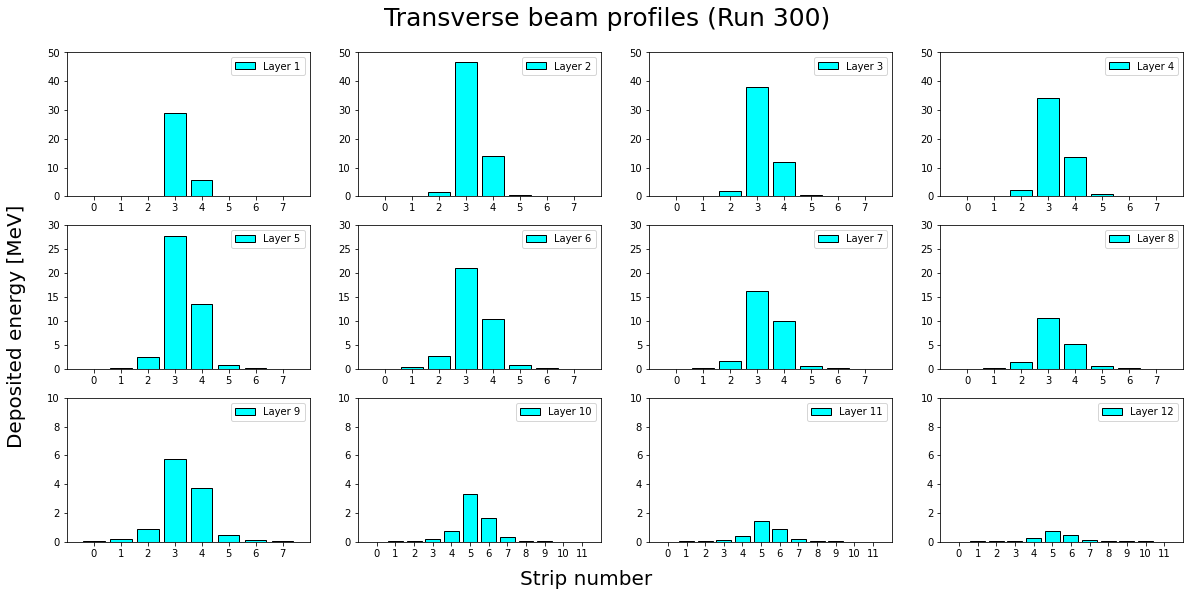

In [82]:
plt.rcParams["figure.figsize"]=(20,9)
for i in range(1,13):
    layered=choose_layer(strip_energy, i)
    
    plt.subplot(3,4,i)
    plt.bar(layered["strip"],(layered["adc_sum_end0"]+layered["adc_sum_end1"])/(2*event_n),
            color='cyan' , edgecolor='black', label="Layer "+str(i))
    plt.legend()
    if i<10:
        plt.xlim(-1,8)
        plt.xticks(np.arange(0,8))
    else:
        plt.xlim(-1,12)
        plt.xticks(np.arange(0,12))
    if i<5:
        plt.ylim(0,50)
    elif i<9:
        plt.ylim(0,30)
    else:
        plt.ylim(0,10)

plt.text(-20, -3, 'Strip number', ha='center', fontsize=20)
plt.text(-51, 15, 'Deposited energy [MeV]', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Transverse beam profiles (Run 300)", y=0.95, fontsize=25)
plt.savefig("plots/run_300_transverse_profile.png", bbox_inches='tight')
plt.show()

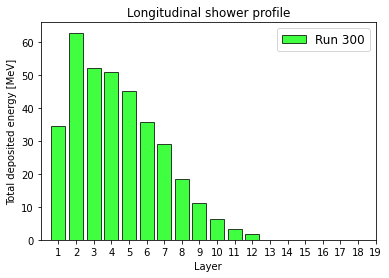

In [68]:
plt.rcParams["figure.figsize"]=(6,4)
plt.bar(layer_energy['layer'], (layer_energy["adc_sum_end0"]+layer_energy["adc_sum_end1"])/(2*event_n), 
        color='lime', alpha=0.75, edgecolor="black", label="Run 300")
plt.xticks(idx)
plt.xlabel("Layer")
plt.ylabel("Total deposited energy [MeV]")
plt.legend(fontsize=12)
plt.title("Longitudinal shower profile")
#plt.savefig("plots/run_300_long_profile.png", bbox_inches='tight')
plt.show()